# Download the Facial dataset of 40 people


In [1]:
!wget www-sop.inria.fr/members/Chuan.Xu/faces.zip

--2023-03-14 11:01:04--  http://www-sop.inria.fr/members/Chuan.Xu/faces.zip
Resolving www-sop.inria.fr (www-sop.inria.fr)... 138.96.0.40
Connecting to www-sop.inria.fr (www-sop.inria.fr)|138.96.0.40|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4363640 (4.2M) [application/zip]
Saving to: ‘faces.zip.1’

faces.zip.1         100%[===================>]   4.16M   615KB/s    in 7.9s    

2023-03-14 11:01:12 (538 KB/s) - ‘faces.zip.1’ saved [4363640/4363640]



In [2]:
import zipfile

with zipfile.ZipFile("faces.zip", "r") as zip_ref:
  zip_ref.extractall("./data")


In [3]:
from skimage.io import imread

image = imread("data/faces/training/s7/1.pgm")


In [4]:
image, type(image), image.shape


(array([[51, 49, 53, ..., 61, 61, 54],
        [52, 51, 50, ..., 60, 61, 55],
        [51, 49, 50, ..., 59, 62, 59],
        ...,
        [52, 51, 49, ..., 63, 59, 63],
        [48, 50, 49, ..., 64, 58, 61],
        [49, 48, 48, ..., 61, 61, 57]], dtype=uint8),
 numpy.ndarray,
 (112, 92))

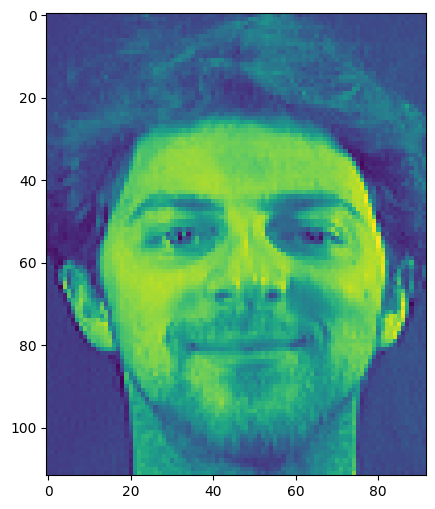

In [5]:
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (8, 6)
plt.imshow(image)


#Training the softmax regression for facial recognition


In [6]:
import torch
import torchvision
from torchvision import transforms

data_transform = transforms.Compose(
  [
    transforms.RandomHorizontalFlip(),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]),
  ]
)
train_dataset = torchvision.datasets.ImageFolder(
  "data/faces/training", transform=data_transform
)
data_loader = torch.utils.data.DataLoader(
  train_dataset, batch_size=64, shuffle=True, num_workers=1
)
net = torch.nn.Linear(112 * 92, 40)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0005)


In [7]:
train_dataset.class_to_idx


{'s1': 0,
 's10': 1,
 's11': 2,
 's12': 3,
 's13': 4,
 's14': 5,
 's15': 6,
 's16': 7,
 's17': 8,
 's18': 9,
 's19': 10,
 's2': 11,
 's20': 12,
 's21': 13,
 's22': 14,
 's23': 15,
 's24': 16,
 's25': 17,
 's26': 18,
 's27': 19,
 's28': 20,
 's29': 21,
 's3': 22,
 's30': 23,
 's31': 24,
 's32': 25,
 's33': 26,
 's34': 27,
 's35': 28,
 's36': 29,
 's37': 30,
 's38': 31,
 's39': 32,
 's4': 33,
 's40': 34,
 's5': 35,
 's6': 36,
 's7': 37,
 's8': 38,
 's9': 39}

In [8]:
for epoch in range(10):
  for imgs, labels in data_loader:
    optimizer.zero_grad()
    imgs = imgs.view(-1, 112 * 92)
    outputs = net(imgs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
  print(f"Epoch {epoch}, loss is {loss.item()}")


Epoch 0, loss is 1.259251594543457
Epoch 1, loss is 0.410908579826355
Epoch 2, loss is 0.2905980348587036
Epoch 3, loss is 0.027338888496160507
Epoch 4, loss is 0.06442391127347946
Epoch 5, loss is 0.10630510747432709
Epoch 6, loss is 0.015825774520635605
Epoch 7, loss is 0.04837026819586754
Epoch 8, loss is 0.00452937139198184
Epoch 9, loss is 0.011976093985140324


# Model inversion steps


In [9]:
import numpy as np

imgs_recover = np.zeros((40, 112, 92))
for label in range(40):
  img_initial = torch.zeros(112 * 92).requires_grad_()
  for i in range(50):
    cost = 1 - torch.nn.functional.softmax(net(img_initial), dim=0)[label]
    cost.backward()
    if i in [0, 49]:
      print(f"Label {label:2d}, Iter {i:2d}: loss {cost:.4f}")
    gradient_img = img_initial.grad.data
    img_initial.data.add_(-0.5, gradient_img)
  img_recovered = img_initial.reshape(112, 92).detach().numpy()
  imgs_recover[label] = img_recovered


Label  0, Iter  0: loss 0.9752
Label  0, Iter 49: loss 0.0000
Label  1, Iter  0: loss 0.9750
Label  1, Iter 49: loss 0.0000
Label  2, Iter  0: loss 0.9753
Label  2, Iter 49: loss 0.0000
Label  3, Iter  0: loss 0.9750
Label  3, Iter 49: loss 0.0000
Label  4, Iter  0: loss 0.9750


/tmp/ipykernel_17046/157826869.py:12: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1174.)
  img_initial.data.add_(-0.5, gradient_img)


Label  4, Iter 49: loss 0.0000
Label  5, Iter  0: loss 0.9749
Label  5, Iter 49: loss 0.0000
Label  6, Iter  0: loss 0.9747
Label  6, Iter 49: loss 0.0000
Label  7, Iter  0: loss 0.9751
Label  7, Iter 49: loss 0.0000
Label  8, Iter  0: loss 0.9749
Label  8, Iter 49: loss 0.0000
Label  9, Iter  0: loss 0.9749
Label  9, Iter 49: loss 0.0000
Label 10, Iter  0: loss 0.9751
Label 10, Iter 49: loss 0.0000
Label 11, Iter  0: loss 0.9749
Label 11, Iter 49: loss 0.0000
Label 12, Iter  0: loss 0.9749
Label 12, Iter 49: loss 0.0000
Label 13, Iter  0: loss 0.9752
Label 13, Iter 49: loss 0.0000
Label 14, Iter  0: loss 0.9748
Label 14, Iter 49: loss 0.0000
Label 15, Iter  0: loss 0.9752
Label 15, Iter 49: loss 0.0000
Label 16, Iter  0: loss 0.9748
Label 16, Iter 49: loss 0.0000
Label 17, Iter  0: loss 0.9750
Label 17, Iter 49: loss 0.0000
Label 18, Iter  0: loss 0.9751
Label 18, Iter 49: loss 0.0000
Label 19, Iter  0: loss 0.9749
Label 19, Iter 49: loss 0.0000
Label 20, Iter  0: loss 0.9749
Label 20

# Recovered images for every person


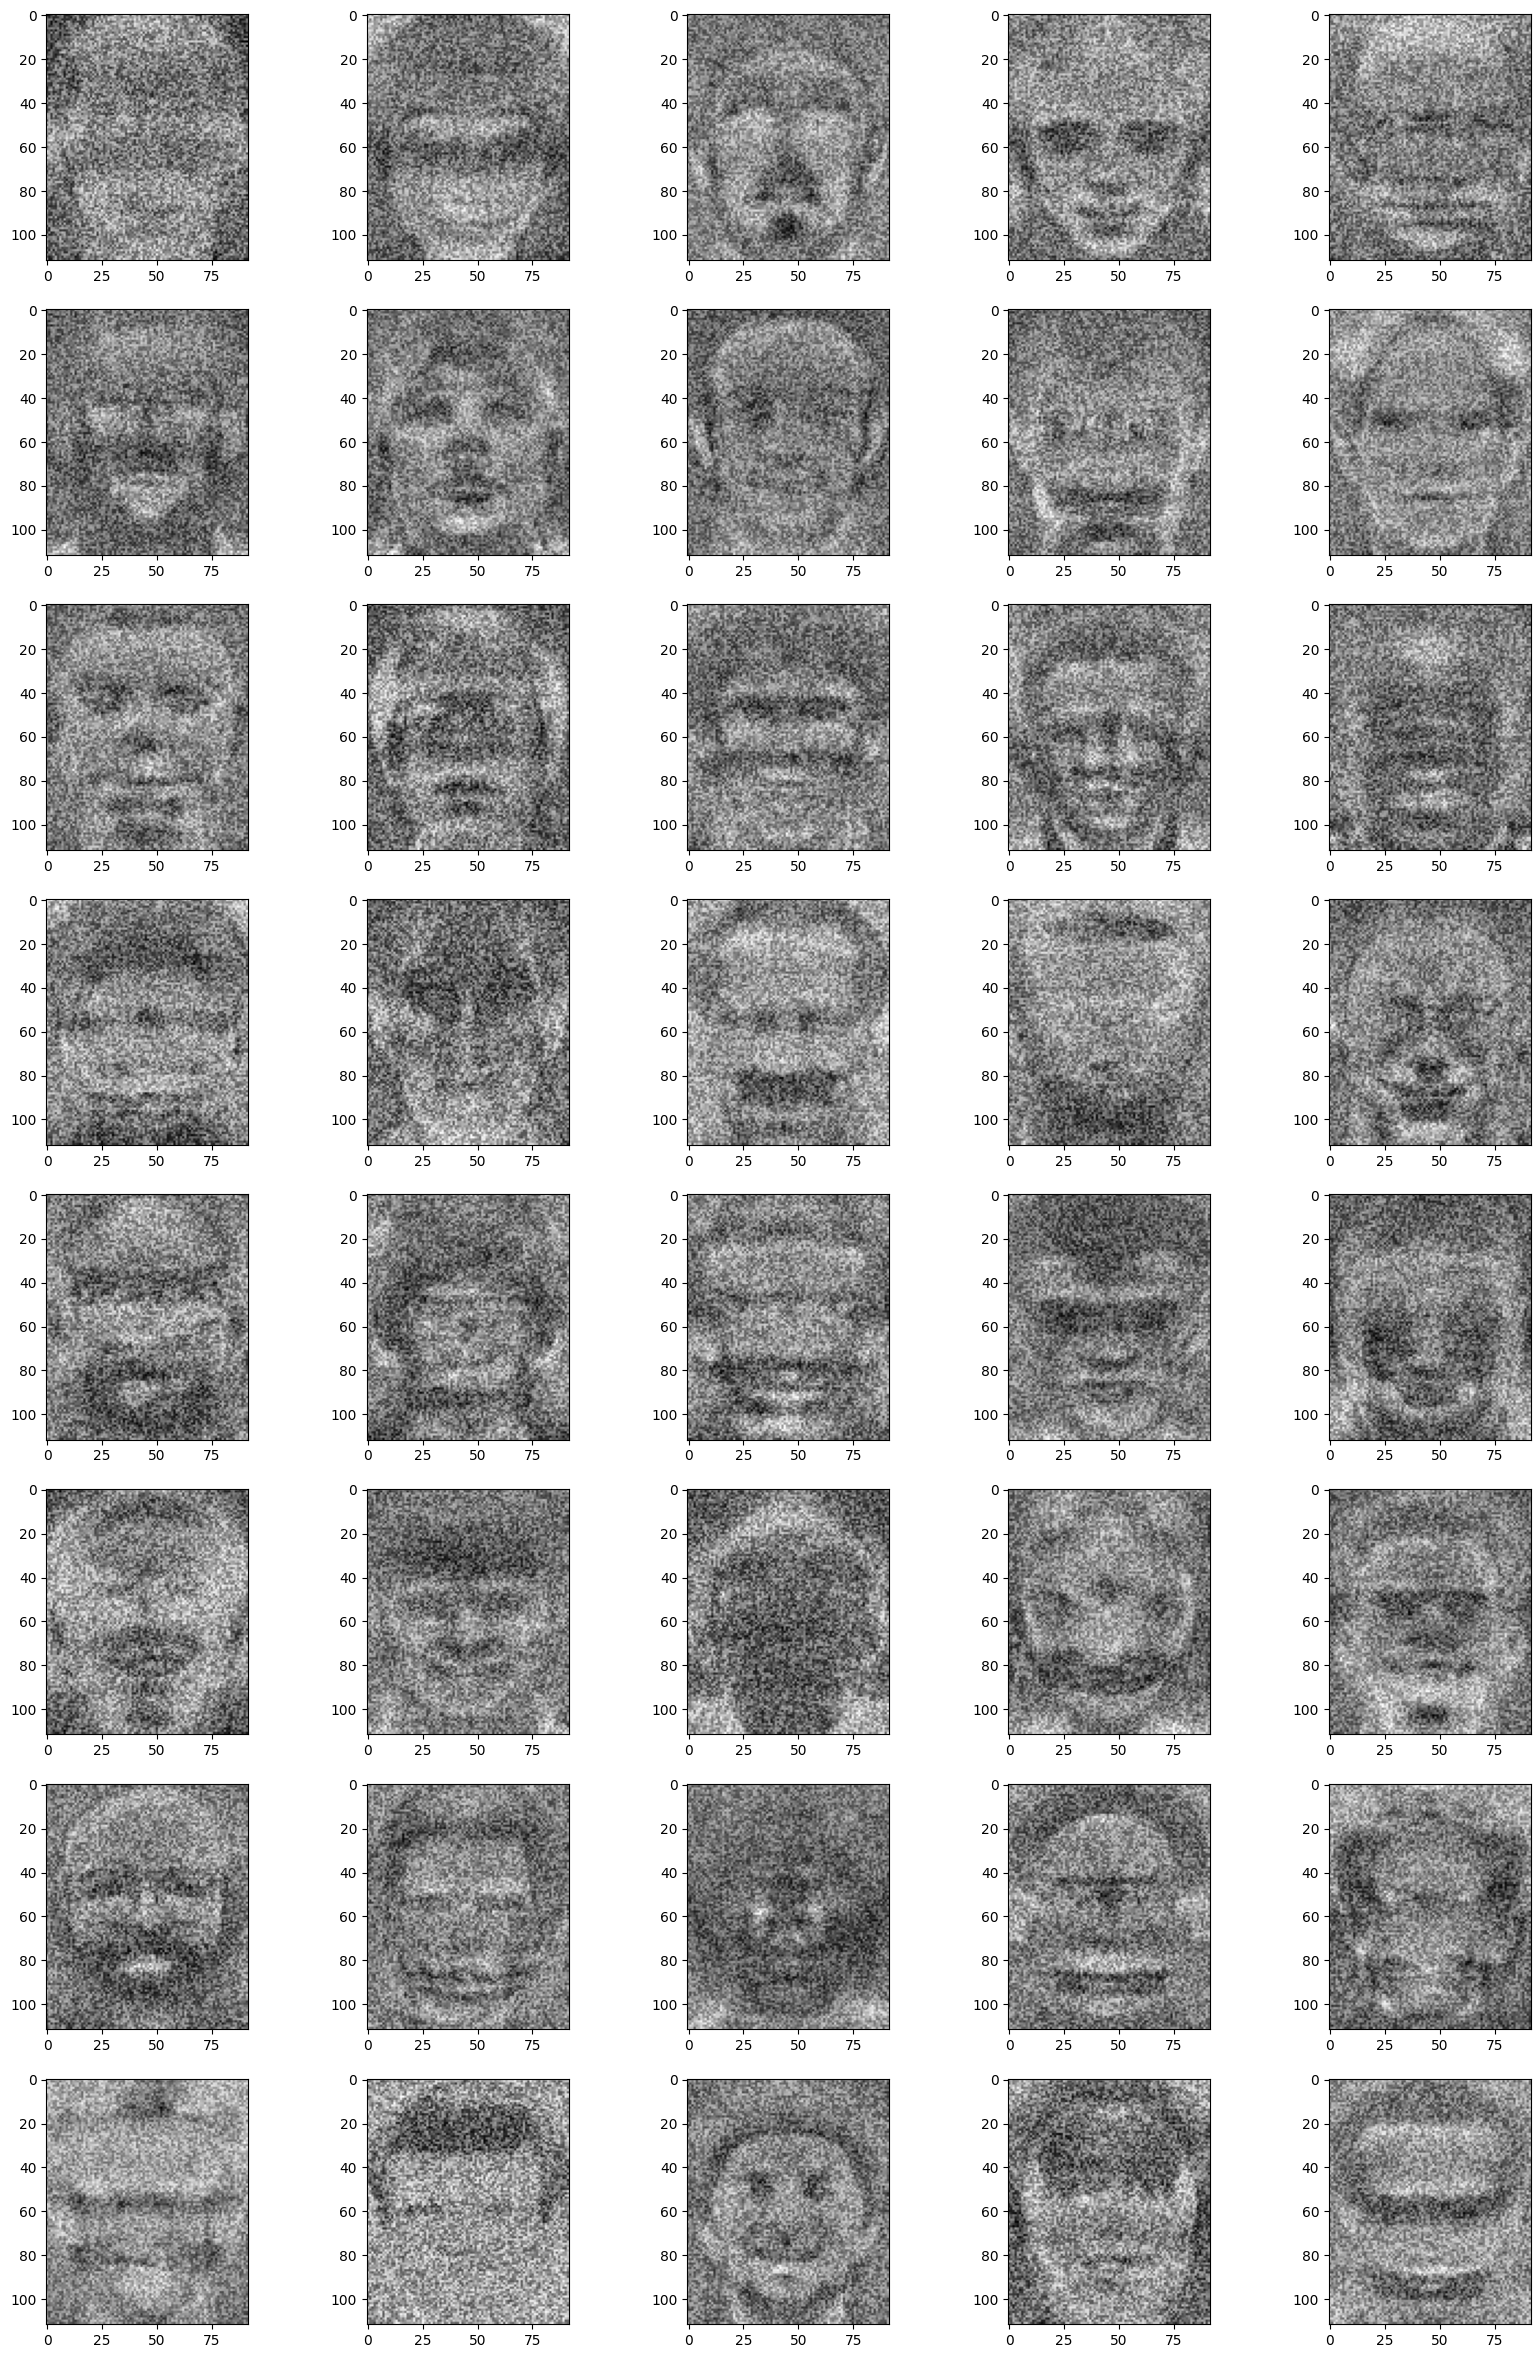

In [10]:
plt.rcParams["figure.figsize"] = (20, 30)
f, axarr = plt.subplots(8, 5)
for i in range(8):
  for j in range(5):
    axarr[i, j].imshow(imgs_recover[i * 5 + j], cmap="gray")


# Trial of neural network (fully connected layers)
